# Imports

In [43]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from cot.models.transformer import Transformer, TransformerConfig
import seaborn as sns
from typing import List
from torch.nn.utils.rnn import pad_sequence

# Hyper-params

In [44]:
epochs = 10
batch_size = 64
n_samples = 10000
min_len = 4
max_len = 10
total_runs = 10

config = TransformerConfig(
    vocab_size=2,
    emb_dim=128,
    n_head=1,
    seq_len=16,
    n_layer=2,
    norm="layer",
    norm_bias=True,
    weight_tying=True,
)


# Model Object

In [45]:
class ParityDataset(Dataset):
    def __init__(self, n_samples=n_samples, min_len=min_len, max_len=max_len):
        self.samples = []
        for _ in range(n_samples):
            length = np.random.randint(min_len, max_len + 1)
            bits = np.random.randint(0, 2, size=length)
            parity = np.cumsum(bits) % 2
            self.samples.append((bits, parity))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)


In [46]:
class ParityTrainer:
    all_accuracies = []

    def __init__(self, config, batch_size=64, epochs=10):
        self.batch_size = batch_size
        self.epochs = epochs
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        def collate_fn(batch):
            xs, ys = zip(*batch)
            xs = pad_sequence(xs, batch_first=True, padding_value=0)
            ys = pad_sequence(ys, batch_first=True, padding_value=0)
            return xs.to(self.device), ys.to(self.device)

        self.train_set = ParityDataset()
        self.train_loader = DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)

        self.model = Transformer(self.config).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracies = []

    def train(self, print_proc = False):
        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0
            for x, y in self.train_loader:
                self.optimizer.zero_grad()
                logits = self.model(x)
                loss = self.criterion(logits.view(-1, 2), y.view(-1))
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            self.model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for x, y in self.train_loader:
                    logits = self.model(x)
                    preds = torch.argmax(logits, dim=-1)
                    correct += (preds == y).sum().item()
                    total += y.numel()
            acc = correct / total
            self.accuracies.append(acc)
            if print_proc:
                print(f"Epoch {epoch}: Loss = {total_loss / len(self.train_loader):.4f}, Accuracy = {acc:.2%}")

        ParityTrainer.all_accuracies.append(self.accuracies)

    def eval(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in self.train_loader:
                logits = self.model(x)
                preds = torch.argmax(logits, dim=-1)
                correct += (preds == y).sum().item()
                total += y.numel()
        print(f"Accuracy: {correct / total:.2%}")

    def plot_accuracy_progress(self):
        plt.plot(self.accuracies)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Progress")
        plt.grid(True)
        plt.show()

    @staticmethod
    def summarize_runs():
        if not ParityTrainer.all_accuracies:
            print("No runs to summarize.")
            return
        max_len = max(len(a) for a in ParityTrainer.all_accuracies)
        padded = [a + [a[-1]] * (max_len - len(a)) for a in ParityTrainer.all_accuracies]
        mean_acc = np.mean(padded, axis=0)
        std_acc = np.std(padded, axis=0)

        plt.plot(mean_acc, label="Mean Accuracy")
        plt.fill_between(range(max_len), mean_acc - std_acc, mean_acc + std_acc, alpha=0.3, label="±1 std")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Average Accuracy Over Runs")
        plt.legend()
        plt.grid(True)
        plt.show()


# Train

In [47]:
trainer = ParityTrainer(config)
trainer.train(print_proc=True)

Epoch 0: Loss = 1.0087, Accuracy = 73.84%
Epoch 1: Loss = 0.4204, Accuracy = 78.78%
Epoch 2: Loss = 0.3829, Accuracy = 79.21%
Epoch 3: Loss = 0.3674, Accuracy = 75.48%
Epoch 4: Loss = 0.3706, Accuracy = 78.86%
Epoch 5: Loss = 0.3679, Accuracy = 78.89%
Epoch 6: Loss = 0.3670, Accuracy = 79.24%
Epoch 7: Loss = 0.3590, Accuracy = 79.26%
Epoch 8: Loss = 0.3587, Accuracy = 79.34%
Epoch 9: Loss = 0.3578, Accuracy = 79.22%


# Evaluation

In [48]:
trainer.eval()

Accuracy: 79.23%


# Visualize

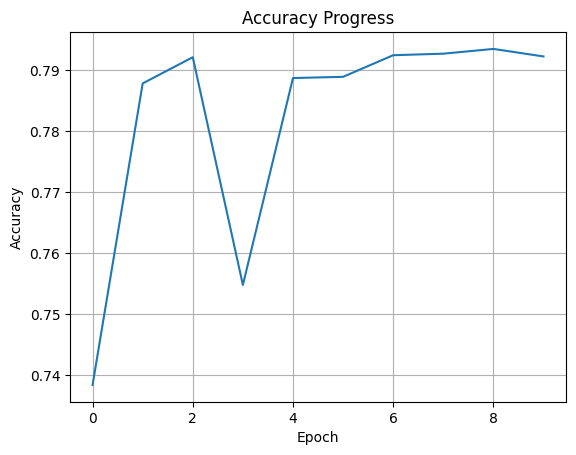

In [49]:
trainer.plot_accuracy_progress()

# Multi-runs

Accuracy: 83.95%
Accuracy: 77.30%
Accuracy: 83.85%
Accuracy: 86.19%
Accuracy: 82.70%
Accuracy: 85.46%
Accuracy: 85.67%
Accuracy: 78.96%
Accuracy: 82.56%
Accuracy: 81.23%


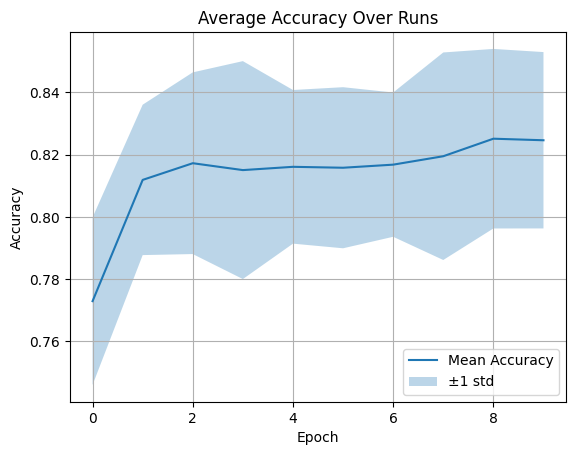

In [50]:
for _ in range(total_runs):
    trainer = ParityTrainer(config)
    trainer.train()
    trainer.eval()

# After several trainers
ParityTrainer.summarize_runs()
